In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.144:35313 Dashboard: http://10.148.0.144:8787/status,Cluster Workers: 10 Cores: 140 Memory: 600.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_work = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_W = xr.open_zarr(out_dir_work+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_work+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/mld_filter.zarr')

ds = xr.merge([ds_W, ds_B, ds_MLD, grid])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day)

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs 

In [6]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

In [7]:
lowcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq

b, a = butter(4, low, 'low')

In [8]:
# filter
W_filter = butter_filter(ds.W.isel(depth=slice(16,39)).sel(time=slice('2011-12-05T23:00:00','2012-02-01T23:00:00')), b, a)
B_filter = butter_filter(ds.Buoy.isel(depth=slice(16,39)).sel(time=slice('2011-12-05T23:00:00','2012-02-01T23:00:00')), b, a)

w_mean = W_filter.mean(['lat','lon']) # spatial mean
b_mean = B_filter.mean(['lat','lon'])
w_prime = W_filter - w_mean
b_prime = B_filter - b_mean

wb_prime_filter = (w_prime*b_prime)
wb_prime_filter

<xarray.DataArray (time: 1393, depth: 23, lat: 201, lon: 177)>
dask.array<mul, shape=(1393, 23, 201, 177), dtype=float32, chunksize=(1393, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 52.69 60.28 68.69 77.97 ... 380.8 410.4 441.3 473.3
  * time     (time) datetime64[ns] 2011-12-05T23:00:00 ... 2012-02-01T23:00:00
    XC       (lat, lon) float32 -18.03125 -18.010416 ... -14.385417 -14.364583
    YC       (lat, lon) float32 47.404716 47.404716 ... 49.98778 49.98778
    CS       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    SN       (lat, lon) float32 -2.519282e-13 -0.0 ... -2.651958e-13
    Depth    (lat, lon) float32 4658.816 4647.708 4628.1807 ... 4070.18 4057.071
    rA       (lat, lon) float32 2302204.5 2302204.5 ... 2089898.9 2089898.9

In [13]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'
D = [xr.open_zarr(out_dir_zarr+'PI_cg_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg = xr.concat(D, dim='depth')
#PI_cg_mean = PI_cg.PI_cg_single.isel(depth=slice(16,39)).mean(['lat','lon'])
PI_cg = PI_cg.isel(depth=slice(16,39))
PI_cg

<xarray.Dataset>
Dimensions:       (depth: 23, lat: 201, lon: 177, time: 1393)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * time          (time) datetime64[ns] 2011-12-05T23:00:00 ... 2012-02-01T23:00:00
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
Dimensions without coordinates: depth
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 1393, 1, 177), meta=np.ndarray>

In [14]:
wb_prime_filter = np.real(wb_prime_filter).rename('wb_prime_filter') 
winter = xr.merge([wb_prime_filter,PI_cg])

sub = 7
winter_sub = winter.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub))
winter_sub

<xarray.Dataset>
Dimensions:          (depth: 23, lat: 29, lon: 26, time: 1393)
Coordinates:
  * depth            (depth) float64 52.69 60.28 68.69 ... 410.4 441.3 473.3
  * lat              (lat) float64 47.4 47.5 47.59 47.68 ... 49.76 49.85 49.94
  * lon              (lon) float64 -18.03 -17.89 -17.74 ... -14.68 -14.53 -14.39
  * time             (time) datetime64[ns] 2011-12-05T23:00:00 ... 2012-02-01T23:00:00
    XC               (lat, lon) float32 -18.03125 -17.885416 ... -14.385417
    YC               (lat, lon) float32 47.404716 47.404716 ... 49.937267
    CS               (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    SN               (lat, lon) float32 -2.519282e-13 ... 2.6498717e-13
    Depth            (lat, lon) float32 4658.816 4601.153 ... 4214.333 4103.661
    rA               (lat, lon) float32 2302204.5 2302204.5 ... 2094022.1
Data variables:
    wb_prime_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(1393, 1, 1, 26), meta=np.ndarray>
  

In [31]:
# save
file_out = out_dir_zarr+'/wb_PI_winter.nc'
%time winter.to_netcdf(file_out, mode='w')   

CPU times: user 1min 17s, sys: 3.84 s, total: 1min 21s
Wall time: 2min 34s


In [16]:
# save
file_out = out_dir_zarr+'/wb_PI_winter_all.nc'
%time winter_sub.to_netcdf(file_out, mode='w')   

CPU times: user 2min 34s, sys: 9.26 s, total: 2min 44s
Wall time: 34min 43s


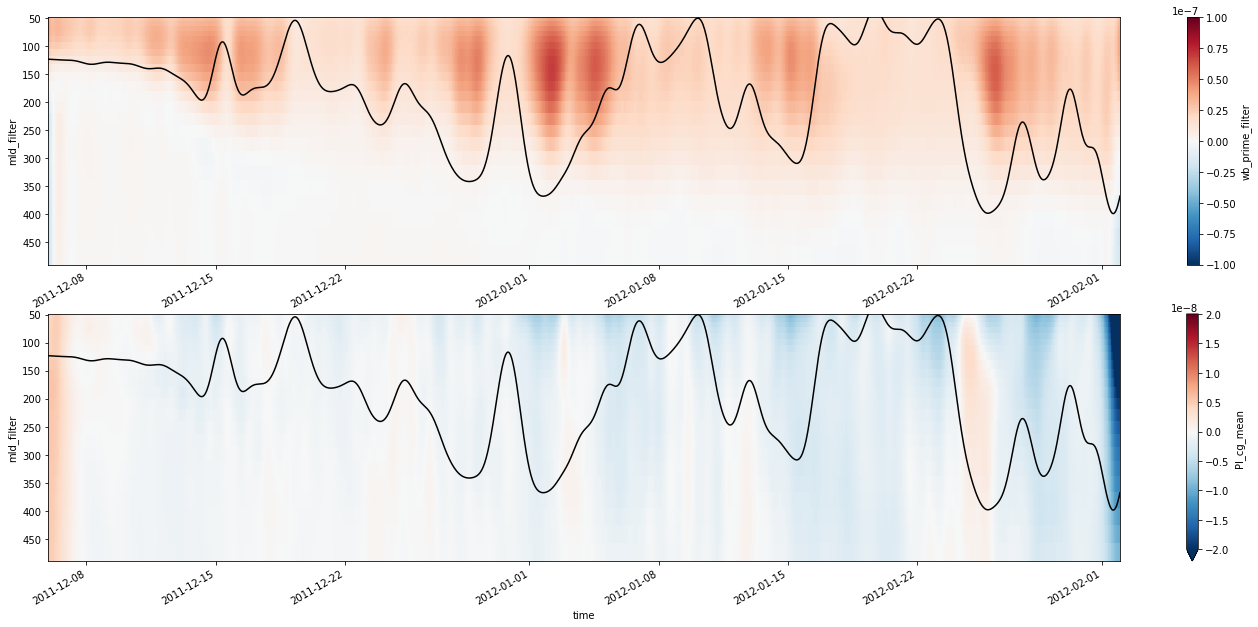

In [30]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
winter.wb_prime_filter.plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds_MLD.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
winter.PI_cg_mean.plot(x='time', y='depth',vmin=-2e-8,vmax=2e-8,cmap='RdBu_r', yincrease=False)
ds_MLD.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

In [17]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1